# 4D Behavioural Vector PDM Generation

> [1] B. G. Cangan, L. Heintzman, A. Hashimoto, N. Abaid, and R. K. Williams, ‘Anticipatory Human-Robot Path Planning for Search and Rescue’, arXiv:2009.03976 [cs], Sep. 2020, Accessed: Nov. 24, 2021. [Online]. Available: http://arxiv.org/abs/2009.03976

> [2] L. Heintzman, A. Hashimoto, N. Abaid, and R. K. Williams, ‘Anticipatory Planning and Dynamic Lost Person Models for Human-Robot Search and Rescue’, in 2021 IEEE International Conference on Robotics and Automation (ICRA), May 2021, pp. 8252–8258. doi: 10.1109/ICRA48506.2021.9562070.

> [3] A. Hashimoto and N. Abaid, ‘An Agent-Based Model of Lost Person Dynamics for Enabling Wilderness Search and Rescue’, presented at the ASME 2019 Dynamic Systems and Control Conference, Nov. 2019. doi: 10.1115/DSCC2019-9222.

In [2]:
# Setup
import sys, os
from loguru import logger

sys.path.insert(0, os.path.join(os.getcwd(), "../src")) # run from within examples folder

os.environ['DEBUG'] = 'True'
if os.environ.get("DEBUG", "False") == "False":
    logger.remove()
    logger.add(sys.stderr, level="INFO")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pydantic
from tqdm.notebook import tqdm
import multiprocessing
from enum import IntEnum
import copy
import rasterio as rs
import skimage as ski
from typing import Union

In [4]:
from jsim.Agent import Agent
from jsim.Meta import Action, State
from jsim.Environment import Environment
from jsim.Simulation import Simulation

In [5]:
class Coord(pydantic.BaseModel, State):
    x: int
    y: int

class BehaviourEnum(IntEnum):
    rw = 0
    lf = 1
    st = 2
    sp = 3

In [88]:
class Direction(Action,IntEnum):
    tl = 0
    t  = 1
    tr = 2
    l  = 3
    sp = 4
    r  = 5
    bl = 6
    b  = 7
    br = 8

    @staticmethod
    def dir_to_coord(d: 'Direction') -> Coord:
        lookup = {
            Direction.tl:(-1,1),
            Direction.t:(0,1),
            Direction.tr:(1,1),
            Direction.l:(-1,0),
            Direction.sp:(0,0),
            Direction.r:(1,0),
            Direction.bl:(-1,-1),
            Direction.b:(0,-1),
            Direction.br:(1,-1)
        }
        x, y = lookup[d]
        return Coord(x=x,y=y)

assert len([Direction(f) for f in range(9)]) == 9

In [20]:
class Vicinity(pydantic.BaseModel, State):
    vicinity: pydantic.conlist(float, min_items=9, max_items=9)

    def __getitem__(self, item):
        return self.vicinity[item]

In [8]:
class Behaviour(pydantic.BaseModel):
    p: pydantic.conlist(float, min_items=9, max_items=9)

    @pydantic.validator('p')
    def p_to_list(cls, v):
        return list(v)

    def __len__(self):
        return 9

    def __getitem__(self, item):
        return self.p[item]

class FourDBehaviours(pydantic.BaseModel):
    rw: Behaviour
    lf: Behaviour
    st: Behaviour
    sp: Behaviour

    def __getitem__(self, item):
        if item == BehaviourEnum.rw:
            return self.rw
        elif item == BehaviourEnum.lf:
            return self.lf
        elif item == BehaviourEnum.st:
            return self.st
        elif item == BehaviourEnum.sp:
            return self.sp
        else:
            raise IndexError(f"{item=} not found in {self}")

    def __len__(self):
        return 4

class BehaviourVector(pydantic.BaseModel):
    rw: float
    lf: float
    st: float
    sp: float

    def __len__(self):
        return 4

    def __getitem__(self, item):
        if item == BehaviourEnum.rw:
            return self.rw
        elif item == BehaviourEnum.lf:
            return self.lf
        elif item == BehaviourEnum.st:
            return self.st
        elif item == BehaviourEnum.sp:
            return self.sp
        else:
            raise IndexError(f"{item=} not found in {self}")

    @pydantic.validator('rw','lf','st','sp', each_item=False)
    @classmethod
    def sum_to_one(cls, v, values, field, config):
        if len(values) == 3:
            s = sum(values.values()) + v
            if np.isclose(s,1):
                return v
            else:
                raise TypeError(f"Values do not sum to 1 ({s},{[v] + [f for f in values.values()]})")
        else:
            return v

    def tolist(self):
        return [self[i] for i in range(len(self))]

BehaviourVector(rw=0.1,lf=0.1,st=0.1,sp=0.7).tolist()

[0.1, 0.1, 0.1, 0.7]

In [90]:
class FourDAgent(Agent):
    def __init__(self, bvec: BehaviourVector, pos: Coord, psim, penv):
        self.psim = psim
        self.penv = penv

        self._behavior = FourDBehaviours(
            rw = Behaviour(p=list(np.ones(9)/9)),
            lf = Behaviour(p=[1/3,1/3,1/3,0,0,0,0,0,0]), # if on a linear feature
            st = Behaviour(p=[0,1,0,0,0,0,0,0,0]),
            sp = Behaviour(p=[0,0,0,0,1,0,0,0,0])
        )
        self.bvec = bvec

        self.direction: Direction = Direction.sp
        self.state = pos

    @pydantic.validate_arguments
    def policy(self, pnext_s: Vicinity) -> Direction:
        choice = np.random.choice(np.arange(0,len(self.bvec)), p=self.bvec.tolist())

        if choice == BehaviourEnum.st:
            new_direction = self.direction
        elif choice == BehaviourEnum.lf:
        # TODO: Encode what to do if there's no lines to follow
            new_direction_rel_to_direction = np.random.randint(-1,1)
            if self.direction == Direction.sp:
                new_direction = Direction.t + new_direction_rel_to_direction
            else:
                loop = np.array([Direction.tl, Direction.t, Direction.tr, Direction.r, Direction.br, Direction.b, Direction.bl, Direction.l])
                ind = np.where(loop == self.direction)[0]
                new_direction = loop[(ind+new_direction_rel_to_direction)%8]
        else:
            new_direction = np.random.choice(np.arange(0, len(self._behavior[choice])), p=self._behavior[choice].p)

        return Direction(new_direction)

    def step(self, pnext_s: Vicinity) -> Direction:
        return self.policy(pnext_s)

    @pydantic.validate_arguments
    def update(self, pa: Direction) -> Coord:
        xy = Direction.dir_to_coord(pa)
        if self.state.x == 0:
            print(self.state)
        self.state.x += xy.x
        self.state.y += xy.y

        self.direction = pa

        return self.state

    @pydantic.validate_arguments
    def reset(self, ps: Coord, vicinity: Vicinity, bvec: BehaviourVector = None) -> tuple[Direction, Coord]:
        self.state = copy.copy(ps)
        if bvec is not None:
            self._bvec = copy.copy(bvec)
        self.direction = Direction.sp

        return self.policy(vicinity), self.state

In [93]:
class FourDEnv(Environment):
    def __init__(self, slope: np.ndarray, psim):
        self.psim = psim

        self.slope = slope
        self.edges = ski.feature.canny(self.slope, sigma=2).astype(int)

    @pydantic.validate_arguments
    def get_vicinity(self, coord: Coord) -> Vicinity:
        vicinity = np.zeros((3,3))
        # TODO check to see if we're at the edge
        vicinity = self.edges[coord.y-1:coord.y+2,coord.x-1:coord.x+2]

        vicinity = vicinity.reshape((9,))

        return Vicinity(vicinity=list(vicinity))

    def reset(self, agent_p: Coord) -> Vicinity:
        return self.get_vicinity(agent_p)

    def step(self, pa: Coord) -> tuple[Vicinity, float]:
        return self.get_vicinity(pa), 0

2022-01-31 18:10:46.466 | DEBUG    | __main__:trials:75 - Iteration 0
2022-01-31 18:10:46.781 | DEBUG    | __main__:trials:75 - Iteration 5
2022-01-31 18:10:47.089 | DEBUG    | __main__:trials:75 - Iteration 10
2022-01-31 18:10:47.409 | DEBUG    | __main__:trials:75 - Iteration 15
2022-01-31 18:10:47.684 | DEBUG    | __main__:trials:75 - Iteration 20
2022-01-31 18:10:47.990 | DEBUG    | __main__:trials:75 - Iteration 25
2022-01-31 18:10:48.275 | DEBUG    | __main__:trials:75 - Iteration 30
2022-01-31 18:10:48.554 | DEBUG    | __main__:trials:75 - Iteration 35
2022-01-31 18:10:48.886 | DEBUG    | __main__:trials:75 - Iteration 40
2022-01-31 18:10:49.174 | DEBUG    | __main__:trials:75 - Iteration 45
2022-01-31 18:10:49.450 | DEBUG    | __main__:trials:75 - Iteration 50
2022-01-31 18:10:49.733 | DEBUG    | __main__:trials:75 - Iteration 55
2022-01-31 18:10:50.028 | DEBUG    | __main__:trials:75 - Iteration 60
2022-01-31 18:10:50.332 | DEBUG    | __main__:trials:75 - Iteration 65
2022-01-

In [ ]:
class Four4DSim(Simulation):
    agent: FourDAgent
    env: FourDEnv

    agent_a: Direction
    agent_s: Coord
    vicinity: Vicinity

    data_store: dict[str,Union[list[Coord],tuple[float,float,float,float]]]

    def __init__(self, initial_pos: Coord):
        self.env = FourDEnv(self._load_slope(), psim=self)

        self.bvecs = iter(self._generate_bvectors())
        self.initial_pos = initial_pos
        self.agent = FourDAgent(bvec=next(self.bvecs),pos=copy.deepcopy(self.initial_pos),psim=self,penv=self.env)

        self.long_term_ds = {}

        self.reset()


    def _load_slope(self) -> np.ndarray:
        dataset_slope = rs.open('./5m_arran_b_merged_slope.tif')

        slope = dataset_slope.read(1)
        slope[slope == -9999.] = 0
        slope = np.deg2rad(slope)

        return slope

    def _generate_bvectors(self) -> list[BehaviourVector]:
        x = np.arange(0,1.1,0.1)
        mesh = np.meshgrid(x,x,x,x)
        vec = np.vstack([f.flatten() for f in mesh])
        vec = vec[:,np.sum(vec,axis=0)==1.0]
        vec[[0,1]] = vec[[1,0]] # prettier graphs

        bvecs: list[BehaviourVector] = [BehaviourVector(rw=f[0], lf=f[1], st=f[2], sp=f[3]) for f in vec.T]

        return bvecs

    def reset(self) -> None:
        self.data_store = {'coords':[], 'bvec':None}
        self.vicinity = self.env.reset(copy.deepcopy(self.initial_pos))
        self.agent_a, self.agent_s = self.agent.reset(copy.deepcopy(self.initial_pos), self.vicinity)

    def trials(self, max_steps_per_trial: int = 300) -> None:
        i = -1
        while True:
            if i%5 == 0:
                logger.debug(f"Iteration {i}")
            try:
                self.steps(max_steps_per_trial)
            except IndexError:
                pass

            self.long_term_ds[(i:=i+1)] = copy.copy(self.data_store)

            try:
                self.agent.bvec = next(self.bvecs)
            except StopIteration:
                break

    def steps(self, num_steps: int) -> None:
        self.reset()

        self.data_store['bvec'] = self.agent.bvec.tolist()
        for _ in range(num_steps):
            vicinity, _ = self.env.step(self.agent_s)

            self.collect_data(self.agent_s)

            agent_a = self.agent.step(vicinity)

            agent_s = self.agent.update(agent_a)

            if agent_s.x <= 0 or agent_s.y <= 0:
                raise IndexError(f"Out of bounds with {agent_s} <= 0")
            if agent_s.x >= self.env.edges.shape[1]-1 or agent_s.y >= self.env.edges.shape[0]-1:
                raise IndexError(f"Out of bounds with {agent_s} >= {[f-1 for f in self.env.edges.shape]}")

            self.agent_a = agent_a
            self.agent_s = agent_s
            self.vicinity = vicinity

    def collect_data(self, ps:Coord) -> None:
        self.data_store['coords'].append(ps)

In [ ]:
sim = Four4DSim(Coord(x=2000,y=2000))
sim.trials()

TypeError: unhashable type: 'Coord'

## Create vectors

Generate all possible 4D vectors with 0.1 increments
Should be length 266 but is 258... is the paper wrong?

In [151]:
x = np.arange(0,1.1,0.1)
mesh = np.meshgrid(x,x,x,x)
vec = np.vstack([f.flatten() for f in mesh])
vec = vec[:,np.sum(vec,axis=0)==1.0]
vec[[0,1]] = vec[[1,0]] # prettier graphs
vec, vec.shape

(array([[0. , 0. , 0. , ..., 0.9, 0.9, 1. ],
        [0. , 0. , 0. , ..., 0. , 0.1, 0. ],
        [0. , 0.1, 0.2, ..., 0.1, 0. , 0. ],
        [1. , 0.9, 0.8, ..., 0. , 0. , 0. ]]),
 (4, 258))

Show all variations

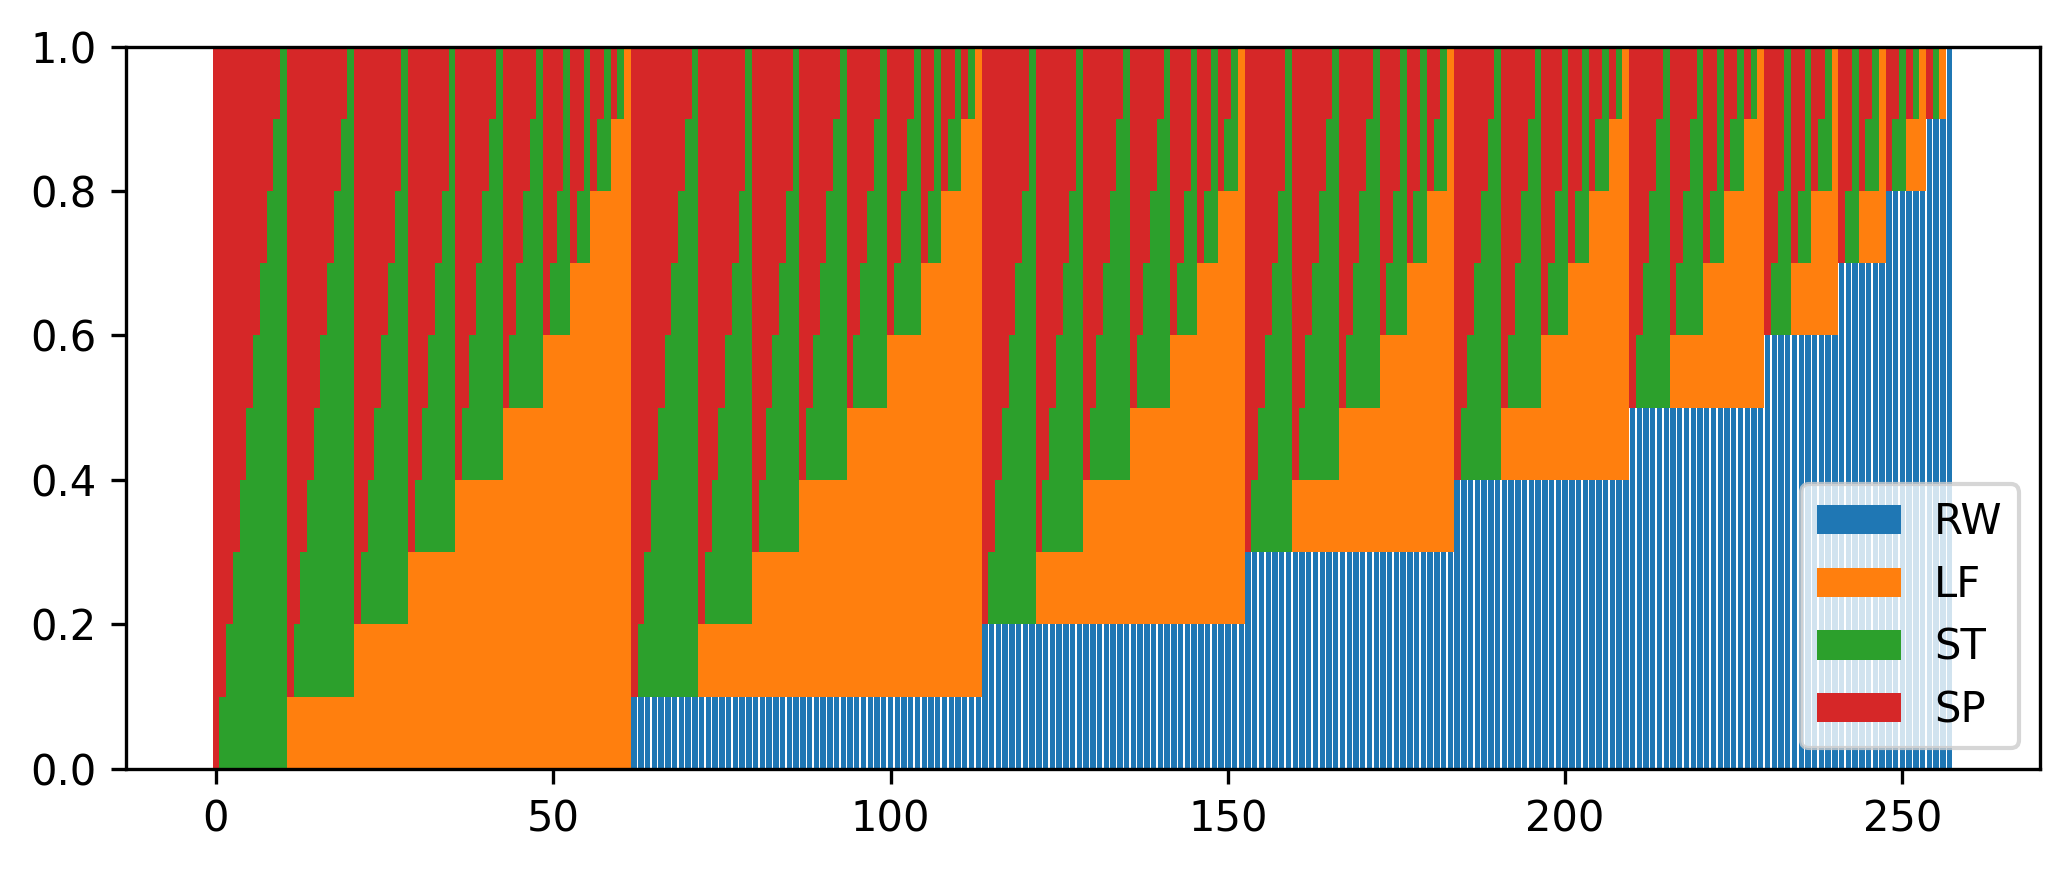

In [152]:
fig, ax = plt.subplots(figsize=(7,3), dpi=300)
x = np.arange(0,vec.shape[1])
labels = iter(['RW','LF','ST','SP'])
ax.bar(x, vec[0,:],label=next(labels))
for i in range(3):
    ax.bar(x, vec[i+1,:], width=1.0, bottom=np.sum(vec[:i+1,:],axis=0), label=next(labels))
ax.legend()
fig.tight_layout()
plt.show()

## Import GeoTIFF image with slope data

> [4]: Lidar Composite Digital Terrain Model Scotland (Phase2) 1m resolution [ASC geospatial data], Scale 1:4000, Tiles: nr82ne,nr83se,nr92nw,nr92sw,nr93sw,nr91ne,nr92ne,nr92se,nr93se,ns02ne,ns02nw,ns02se,ns02sw,ns03se,ns03sw, Updated: 1 July 2014, Non-Commercial Government Licence, Using: EDINA LIDAR Digimap Service, <https://digimap.edina.ac.uk>, Downloaded: 2022-01-28 13:08:03.643

In [102]:
import rasterio as rs
dataset_slope = rs.open('./5m_arran_b_merged_slope.tif')
dataset_dem = rs.open('./5m_arran_b_merged.tif')

slope = dataset_slope.read(1)
slope[slope == -9999.] = 0
slope = np.deg2rad(slope) # so we don't have to worry anymore

dem = dataset_dem.read(1)

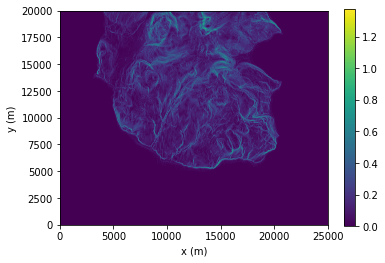

In [7]:
fig, ax = plt.subplots()
mesh = ax.imshow(slope, extent=[0,5000*5,0,4000*5])
fig.colorbar(mesh)
ax.set_ylabel("y (m)")
ax.set_xlabel("x (m)")
plt.show()

## Canny edge detection
https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html

In [8]:
from skimage import feature

edges_rough = feature.canny(slope).astype(int)
edges = feature.canny(slope, sigma=3).astype(int)

Display results

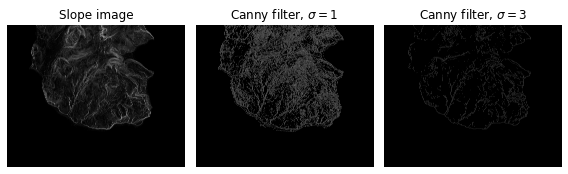

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax1.imshow(slope, cmap='gray')
ax1.set_title('Slope image')

ax2.imshow(edges_rough, cmap='gray')
ax2.set_title(r'Canny filter, $\sigma=1$')

ax3.imshow(edges, cmap='gray')
ax3.set_title(r'Canny filter, $\sigma=3$')

for a in [ax1,ax2,ax3]:
    a.axis('off')

fig.tight_layout()
plt.show()

## Implement the code

In [10]:
def sim(prob_vec, edge_map, c: int, x0 = 3000, y0 = 2000, T=500) -> tuple[list[float],list[float], int]:
    x = x0
    y = y0
    x_path = [x]
    y_path = [y]
    for i in range(T):
        strat = np.random.choice(np.arange(4), p=prob_vec)

        if strat == 0:
            # RW
            vx, vy = np.random.randint(-1,2, size=(2,))

        elif strat == 1:
            # LF
            vicinity = edge_map[x-1:x+2,y-1:y+2]

            if (vicinity == 1).any():
                direction = np.random.choice(np.where(vicinity==1)[0])
                lookup = {0:(-1,1),1:(0,1),2:(1,1),3:(-1,0),4:(0,0),5:(1,0),6:(-1,-1),7:(0,-1),8:(1,-1)}
                vx, vy = lookup[direction]
            else:
                vx, vy = np.random.randint(-1,2,size=(2,))
        elif strat == 3:
            # ST
            vx = 0
            vy = 1
        else:
            # SP
            vx = 0
            vy = 0

        x += vx
        y += vy

        x_path.append(x)
        y_path.append(y)
    return x_path, y_path, c

In [11]:
x_path = {}
y_path = {}

with multiprocessing.Pool(8) as pool:
    logger.debug(f"Simulation started")
    results = [pool.apply_async(sim, (vec[:,i], edges_rough, i)) for i in range(vec.shape[1])]
    logger.debug(f"Simulation complete")

    for r in results:
        x_arr, y_arr, c = r.get()
        x_path[c] = x_arr
        y_path[c] = y_arr


  0%|          | 0/258 [00:00<?, ?it/s]

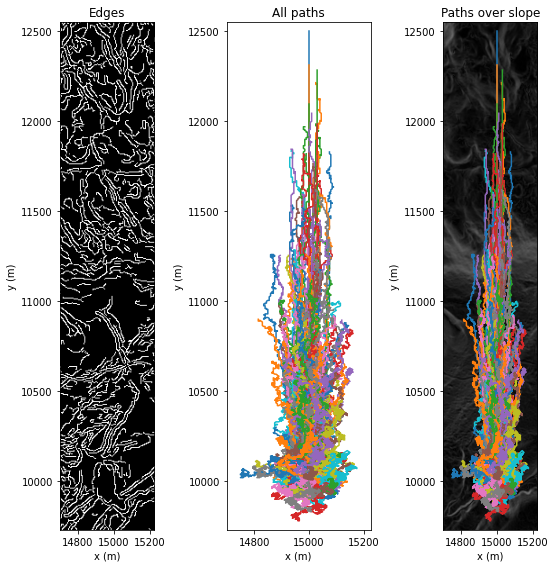

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(8,8))

ax1.imshow(edges_rough, cmap='gray', extent=[0,5000*5,0,4000*5])
ax3.imshow(slope, cmap='gray', extent=[0,5000*5,0,4000*5])

max_x, min_x = -np.inf, np.inf
max_y, min_y = -np.inf, np.inf

for i in tqdm(range(vec.shape[1])):
    x, y = np.array([x_path[i], y_path[i]])*5 # scale as each pixel is 5m
    max_x = max(max_x, np.max(x))
    min_x = min(min_x, np.min(x))
    max_y = max(max_y, np.max(y))
    min_y = min(min_y, np.min(y))
    [ax.plot(x, y) for ax in [ax2,ax3]]

for ax in [ax1,ax2,ax3]:
    ax.set_ylim([min_y-50, 50+max_y])
    ax.set_xlim([min_x-50, 50+max_x])
    ax.set_ylabel("y (m)")
    ax.set_xlabel("x (m)")

ax1.set_title("Edges")
ax2.set_title("All paths")
ax3.set_title("Paths over slope")
fig.tight_layout()
plt.show()

## Use agent to generate PDM
TODO: Select "best" agent. Pick one at random for now

> Simulations were run for the time it would take for a
person to walk an hour with an average pace of 4 kilometers an
hour and with a time step of 6 seconds, that is T = 600.

- [3]

Thus, each cell is $5m$ wide. Not accounting for diagonal steps, slope, etc., we run the simulation for $800$ timesteps.

In [13]:
agent = vec[:,np.random.randint(0,vec.shape[1])]
logger.info(f"Selected {agent=}")

end_locations = []

for i in tqdm(range(5000)):
    x_arr, y_arr, _ = sim(agent, edges_rough, i, T=400)
    end_locations.append((x_arr[-1],y_arr[-1]))

2022-01-28 17:40:14.489 | INFO     | __main__:<module>:2 - Selected agent=array([0.2, 0.1, 0.2, 0.5])


  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
end_locations = np.array(end_locations)
min_x, min_y = np.min(end_locations, axis=0)
max_x, max_y = np.max(end_locations, axis=0)
end_locations[:,0] -= min_x
end_locations[:,1] -= min_y

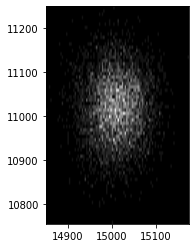

In [15]:
z = np.zeros((max_x-min_x+1, max_y-min_y+1))
for xi, yi in end_locations:
    z[xi,yi] += 1
z /= np.sum(z)

fig, ax = plt.subplots()

ax.imshow(z, cmap='gray', extent=np.array([min_x, max_x, min_y, max_y])*5, alpha=1)

plt.show()